# Preprocessing SODA and Training GNNs

by Ding

## 1. Preprocessing

In [1]:
!pip install geopandas

import numpy as np
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

from google.colab import drive
drive.mount("/gdrive", force_remount=True)

!cp -a "/gdrive/MyDrive/soda_331_pt_l5.nc" "/content/"

     |████████████████████████████████| 1.0 MB 4.0 MB/s 
     |████████████████████████████████| 16.7 MB 47.5 MB/s 
     |████████████████████████████████| 6.3 MB 24.3 MB/s 
Mounted at /gdrive


In [2]:
soda = xr.open_dataset("soda_331_pt_l5.nc", decode_times=False)

soda_array = soda.to_array(dim="temp")
soda_smaller = soda_array[:,:,:,::5,::5].to_dataset(dim="temp")

start_year = 1980
end_year = 2009
target_year = end_year + +1
start_month = (start_year - 1980) * 12
end_month = (end_year + 1 - 1980) * 12

soda_sst_1980_2009 = np.zeros((end_month-start_month+12,1,66,144)) # Include one more year.
soda_sst_1980_2009[:,:,:,:] = soda_smaller.variables["temp"][0:end_month-start_month+12,:,:,:]
soda_sst_1980_2009 = np.squeeze(soda_sst_1980_2009, axis=1)
print(soda_sst_1980_2009.shape)

soda_sst_2010 = np.zeros((12,1,66,144))
soda_sst_2010[:,:,:,:] = soda_smaller.variables["temp"][end_month-start_month:end_month-start_month+12,:,:,:]
soda_sst_2010 = np.squeeze(soda_sst_2010, axis=1)
print(soda_sst_2010.shape)

(372, 66, 144)
(12, 66, 144)


In [3]:
soda_sst_1980_2009_transposed = soda_sst_1980_2009.transpose(1,2,0)
soda_sst_1980_2009_flattened = soda_sst_1980_2009_transposed.reshape(soda_sst_1980_2009.shape[1] * soda_sst_1980_2009.shape[2],len(soda_sst_1980_2009))
print(soda_sst_1980_2009_flattened.shape)

soda_sst_2010_transposed = soda_sst_2010.transpose(1,2,0)
soda_sst_2010_flattened = soda_sst_2010_transposed.reshape(soda_sst_2010.shape[1] * soda_sst_2010.shape[2],len(soda_sst_2010))
print(soda_sst_2010_flattened.shape)

(9504, 372)
(9504, 12)


In [4]:
def dropna(arr, *args, **kwarg):
    assert isinstance(arr, np.ndarray)
    dropped=pd.DataFrame(arr).dropna(*args, **kwarg).values
    if arr.ndim==1:
        dropped=dropped.flatten()
    return dropped

soda_sst_ocean_1980_2009_flattened = dropna(soda_sst_1980_2009_flattened)
print(soda_sst_ocean_1980_2009_flattened.shape)

soda_sst_ocean_2010_flattened = dropna(soda_sst_2010_flattened)
print(soda_sst_ocean_2010_flattened.shape)

(6924, 372)
(6924, 12)


In [5]:
target_month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
#target_month = ["Jan"]

soda_sst_ocean_1980_2009_flattened_all = []
soda_sst_ocean_2010_mhw_all = []

for month in target_month:

  index = target_month.index(month)
  soda_sst_ocean_1980_2009_flattened_all.append(soda_sst_ocean_1980_2009_flattened[:,index:(index+soda_sst_ocean_1980_2009_flattened.shape[1]-12)])

  soda_sst_ocean_2010_mhw = []
  for row in range(len(soda_sst_ocean_1980_2009_flattened)):
    sst_node = soda_sst_ocean_1980_2009_flattened[row][index::12]
    #print(np.mean(sst_node))
    if soda_sst_ocean_2010_flattened[row][index] > sorted(sst_node)[-4]:
      soda_sst_ocean_2010_mhw.append(1)
    else:
      soda_sst_ocean_2010_mhw.append(0)
  
  print(month, target_year, ":", soda_sst_ocean_2010_mhw.count(1), "MHW")
  print(month, target_year, ":", soda_sst_ocean_2010_mhw.count(0), "no MHW")
  print()

  soda_sst_ocean_2010_mhw = np.array(soda_sst_ocean_2010_mhw)
  soda_sst_ocean_2010_mhw_all.append(soda_sst_ocean_2010_mhw)

Jan 2010 : 1318 MHW
Jan 2010 : 5606 no MHW

Feb 2010 : 1427 MHW
Feb 2010 : 5497 no MHW

Mar 2010 : 1542 MHW
Mar 2010 : 5382 no MHW

Apr 2010 : 1440 MHW
Apr 2010 : 5484 no MHW

May 2010 : 1370 MHW
May 2010 : 5554 no MHW

Jun 2010 : 1363 MHW
Jun 2010 : 5561 no MHW

Jul 2010 : 1283 MHW
Jul 2010 : 5641 no MHW

Aug 2010 : 1444 MHW
Aug 2010 : 5480 no MHW

Sep 2010 : 1413 MHW
Sep 2010 : 5511 no MHW

Oct 2010 : 1368 MHW
Oct 2010 : 5556 no MHW

Nov 2010 : 1251 MHW
Nov 2010 : 5673 no MHW

Dec 2010 : 1367 MHW
Dec 2010 : 5557 no MHW



In [6]:
lons, lats = np.meshgrid(soda_smaller.longitude.values, soda_smaller.latitude.values)

soda_time_1 = soda_smaller.temp.isel(depth=0,time=240)
soda_time_1_lons, soda_time_1_lats = np.meshgrid(soda_time_1.longitude.values, soda_time_1.latitude.values)
soda_masked = soda_time_1.where(abs(soda_time_1_lons) + abs(soda_time_1_lats) > 0)

soda_masked.values.flatten()[soda_masked.notnull().values.flatten()]

from sklearn.metrics.pairwise import haversine_distances

lons_ocean = soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()]
lons_ocean = lons_ocean[::]
lats_ocean = soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()]
lats_ocean = lats_ocean[::]

lons_ocean *= np.pi/180
lats_ocean *= np.pi/180

points_ocean = np.concatenate([np.expand_dims(lats_ocean.flatten(),-1), np.expand_dims(lons_ocean.flatten(),-1)],-1)

distance_ocean = 6371*haversine_distances(points_ocean)

distance_ocean_diag = distance_ocean
distance_ocean_diag[distance_ocean_diag==0] = 1

distance_ocean_recip = np.reciprocal(distance_ocean_diag)

distance_ocean_recip.shape

(6924, 6924)

In [7]:
adjacency_matrix = distance_ocean_recip

w = []

for i in range(distance_ocean_recip.shape[0]):
  for j in range(distance_ocean_recip.shape[1]):
    if i != j:
      w.append(distance_ocean_recip[i][j])

## 2. GNN

In [8]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

import random

import torch

import dgl
import dgl.nn as dglnn
import dgl.data
import torch.nn as nn
import torch.nn.functional as F

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 6.1 MB 732 kB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [9]:
node_num = len(soda_sst_ocean_1980_2009_flattened_all[index])

def graph_structure():
  u = []
  v = []
  for i in range(node_num):
    for j in range(node_num):
      if j == i:
        pass
      else:
        u.append(i)
        v.append(j)
  return torch.tensor(u), torch.tensor(v)
  
u, v = graph_structure()
graph = dgl.graph((u, v))

In [10]:
weights = torch.tensor(w)

In [11]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [12]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # Inputs are features of nodes.
        h = self.conv1(graph, inputs)
        h = torch.tanh(h) # sigmoid(h), relu(h)
        h = self.conv2(graph, h)
        return h

def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        #print("Validation / test observed class:", labels.tolist(), "| predicted class:", indices.tolist())
        #correct = torch.sum(indices == labels)
        combine = indices + labels
        accuracy = torch.sum(indices == labels).item() * 1.0 / len(labels)
        precision = (torch.sum(combine == 2).item() * 1.0) / (torch.sum(labels == 1).item() * 1.0)

        tp = (torch.sum(combine == 2).item() * 1.0)
        fp = (torch.sum(labels == 1).item() * 1.0) - (torch.sum(combine == 2).item() * 1.0)
        tn = (torch.sum(combine == 0).item() * 1.0)
        fn = (torch.sum(indices == 1).item() * 1.0) - (torch.sum(combine == 2).item() * 1.0)
        kappa = (2 * (tp * tn - fn * fp)) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))

        return accuracy, precision, kappa

In [ ]:
test_results = []

for month in target_month:
  
  print("--------------------")
  print("Start training for", month, ".")
  print()

  index = target_month.index(month)
  node_num = len(soda_sst_ocean_1980_2009_flattened_all[index])

  node_feature = torch.tensor(soda_sst_ocean_1980_2009_flattened_all[index])
  node_class = torch.tensor(soda_sst_ocean_2010_mhw_all[index])

  graph.ndata["feat"] = node_feature
  graph.ndata["label"] = node_class

  graph.edata['w'] = weights

  def masks():
    train = [True] * node_num
    val = [False] * node_num
    test = [False] * node_num
    randomlist = []
    for i in range(0, round(node_num * 0.3)):
      n = random.randint(0, node_num-1) # Need to substract 1 to be in the list index range.
      randomlist.append(n)
    #print(randomlist)
    randomlist_split = list(split(randomlist, 3))
    for i in randomlist_split[0]:
      val[i] = True
    for i in randomlist_split[1]:
      test[i] = True
    for i in randomlist_split[2]:
      test[i] = True
    for i in randomlist:
      train[i] = False
    #print("Training mask:")
    #print(train)
    return torch.tensor(train), torch.tensor(val), torch.tensor(test)

  graph.ndata["train_mask"], graph.ndata["val_mask"], graph.ndata["test_mask"] = masks()
  #print(graph.ndata)

  node_features = graph.ndata['feat']
  node_labels = graph.ndata['label']
  train_mask = graph.ndata['train_mask']
  valid_mask = graph.ndata['val_mask']
  test_mask = graph.ndata['test_mask']
  n_features = node_features.shape[1]
  n_labels = int(node_labels.max().item() + 1)

  model = SAGE(in_feats=n_features, hid_feats=200, out_feats=n_labels)
  #opt = torch.optim.Adam(model.parameters(), lr=0.0005)
  opt = torch.optim.SGD(model.parameters(), lr=0.0001) #momentum=0.9

  for epoch in range(5):
      print("Epoch:", epoch+1)
      model.train()
      # Forward propagation by using all nodes
      logits = model(graph, node_features.float())
      # Compute loss.
      loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
      # Compute validation accuracy.
      acc, pre, kappa = evaluate(model, graph, node_features.float(), node_labels, valid_mask)
      # Backward propagation
      opt.zero_grad()
      loss.backward()
      opt.step()
      print("Training loss: %.4f" % loss.item(), "| validation accuracy: %.4f" % acc, "| validation precision: %.4f" % pre, "| test kappa statistics: %.4f" % kappa)
      print()

  print("----------")
  test_acc, test_pre, test_kappa = evaluate(model, graph, node_features.float(), node_labels, test_mask)
  print("Test accuracy: %.4f" % test_acc, "| test precision: %.4f" % test_pre, "| test kappa statistics: %.4f" % test_kappa)
  
  test_results.append([test_acc, test_pre, test_kappa])
  print("The test results for", month, "have been appended.")
  print()

--------------------
Start training for Jan .

Epoch: 1
Training loss: 1.0955 | validation accuracy: 0.4614 | validation precision: 0.4690 | test kappa statistics: -0.0389

Epoch: 2
Training loss: 1.0196 | validation accuracy: 0.4841 | validation precision: 0.4690 | test kappa statistics: -0.0246

Epoch: 3
Training loss: 0.9540 | validation accuracy: 0.4887 | validation precision: 0.4336 | test kappa statistics: -0.0382

Epoch: 4
Training loss: 0.8997 | validation accuracy: 0.4932 | validation precision: 0.3982 | test kappa statistics: -0.0524

Epoch: 5
Training loss: 0.8553 | validation accuracy: 0.5038 | validation precision: 0.3805 | test kappa statistics: -0.0544

----------
Test accuracy: 0.5239 | test precision: 0.3739 | test kappa statistics: -0.0453
The test results for Jan have been appended.

--------------------
Start training for Feb .

Epoch: 1
Training loss: 0.9468 | validation accuracy: 0.5015 | validation precision: 0.7308 | test kappa statistics: 0.1046

Epoch: 2
Train

In [ ]:
for element in test_results:
  print(element)
for element in test_results:
  print(round(element[0], 4), "&", round(element[1], 4), "&", round(element[2], 4))

[0.5238853503184714, 0.3739495798319328, -0.0452566771690362]
[0.6053054662379421, 0.5019762845849802, 0.09888054196639856]
[0.39437751004016064, 0.8047138047138047, 0.04059481833512188]
[0.7824701195219124, 0.0, 0.0]
[0.5324881141045958, 0.6877470355731226, 0.11057330501489585]
[0.8207171314741036, 0.0, 0.0]
[0.8001605136436597, 0.02242152466367713, -0.011726418355301346]
[0.8033175355450237, 0.0, 0.0]
[0.39564867042707497, 0.7786561264822134, 0.039332905338037155]
[0.7379636937647988, 0.025, -0.04788476964391588]
[0.8123003194888179, 0.0, 0.0]
[0.5741626794258373, 0.3448275862068966, -0.020929764540148922]
0.5239 & 0.3739 & -0.0453
0.6053 & 0.502 & 0.0989
0.3944 & 0.8047 & 0.0406
0.7825 & 0.0 & 0.0
0.5325 & 0.6877 & 0.1106
0.8207 & 0.0 & 0.0
0.8002 & 0.0224 & -0.0117
0.8033 & 0.0 & 0.0
0.3956 & 0.7787 & 0.0393
0.738 & 0.025 & -0.0479
0.8123 & 0.0 & 0.0
0.5742 & 0.3448 & -0.0209


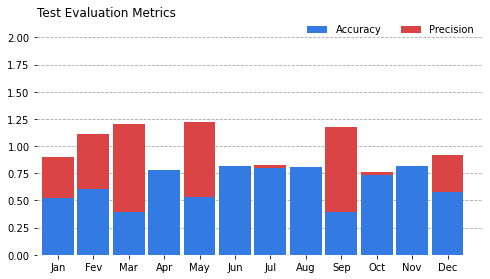

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

d = {'Accuracy':[test_results[i][0] for i in range(len(test_results))], 'Precision': [test_results[i][1] for i in range(len(test_results))]}
result_df = pd.DataFrame(data=d)
result_df

fig, ax = plt.subplots(1, figsize=(8, 4))
plt.bar(result_df.index, result_df['Accuracy'], color = '#337AE3', width = 0.9)
plt.bar(result_df.index, result_df['Precision'], bottom = result_df['Accuracy'], color = '#DB4444', width = 0.9)
plt.xlim(-0.6, 12)
plt.ylim(0, 2)# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)#grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)# x ticks
xticks_labels = ['Jan', 'Fev', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(result_df.index , labels = xticks_labels)# title and legend
legend_label = ['Accuracy', 'Precision']
plt.legend(legend_label, ncol = 4, bbox_to_anchor=([1, 1.1, 0, 0]), frameon = False)
plt.title('Test Evaluation Metrics\n', loc='left')
plt.show()

In [55]:
test_results = []

for month in target_month:
  
  print("--------------------")
  print("Start training for", month)
  print()

  index = target_month.index(month)
  node_num = len(soda_sst_ocean_1980_2009_flattened_all[index])

  node_feature = torch.tensor(soda_sst_ocean_1980_2009_flattened_all[index])
  node_class = torch.tensor(soda_sst_ocean_2010_mhw_all[index])

  graph.ndata["feat"] = node_feature
  graph.ndata["label"] = node_class

  graph.edata['w'] = weights

  def masks():
    train = [True] * node_num
    val = [False] * node_num
    test = [False] * node_num
    randomlist = []
    for i in range(0, round(node_num * 0.3)):
      n = random.randint(0, node_num-1) # Need to substract 1 to be in the list index range.
      randomlist.append(n)
    #print(randomlist)
    randomlist_split = list(split(randomlist, 3))
    for i in randomlist_split[0]:
      val[i] = True
    for i in randomlist_split[1]:
      test[i] = True
    for i in randomlist_split[2]:
      test[i] = True
    for i in randomlist:
      train[i] = False
    #print("Training mask:")
    #print(train)
    return torch.tensor(train), torch.tensor(val), torch.tensor(test)

  graph.ndata["train_mask"], graph.ndata["val_mask"], graph.ndata["test_mask"] = masks()
  #print(graph.ndata)

  node_features = graph.ndata['feat']
  node_labels = graph.ndata['label']
  train_mask = graph.ndata['train_mask']
  valid_mask = graph.ndata['val_mask']
  test_mask = graph.ndata['test_mask']
  n_features = node_features.shape[1]
  n_labels = int(node_labels.max().item() + 1)

  NUM_MODEL = 5
  
  sum_test_acc = 0
  sum_test_pre = 0
  sum_test_kappa = 0

  for time in range(NUM_MODEL):
    
    print()
    print("Start training Model", str(time+1))
    print()

    model = SAGE(in_feats=n_features, hid_feats=200, out_feats=n_labels)
    #opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    opt = torch.optim.SGD(model.parameters(), lr=0.0001) #momentum=0.9

    for epoch in range(5):
        print("Epoch:", epoch+1)
        model.train()
        # Forward propagation by using all nodes
        logits = model(graph, node_features.float())
        # Compute loss.
        loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
        # Compute validation accuracy.
        acc, pre, kappa = evaluate(model, graph, node_features.float(), node_labels, valid_mask)
        # Backward propagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        print("Training loss: %.4f" % loss.item(), "| validation accuracy: %.4f" % acc, "| validation precision: %.4f" % pre, "| test kappa statistics: %.4f" % kappa)
        print()

    print("----------")
    test_acc, test_pre, test_kappa = evaluate(model, graph, node_features.float(), node_labels, test_mask)
    print("Test accuracy: %.4f" % test_acc, "| test precision: %.4f" % test_pre, "| test kappa statistics: %.4f" % test_kappa)

    sum_test_acc += test_acc
    sum_test_pre += test_pre
    sum_test_kappa += test_kappa
    
    if test_acc > 0.5 and test_pre > 0.5:
      logits = model(graph, node_features.float())
      fine_predicted_values = logits[test_mask]
      fine_labels = node_labels[test_mask]
      fine_test_masks = test_mask
  
  test_acc = sum_test_acc / NUM_MODEL
  test_pre = sum_test_pre / NUM_MODEL
  test_kappa = sum_test_kappa / NUM_MODEL

  test_results.append([test_acc, test_pre, test_kappa])
  print()
  print("--------------------")
  print("Average test accuracy: %.4f" % test_acc, "| average test precision: %.4f" % test_pre, "| average test kappa statistics: %.4f" % test_kappa)
  print()
  print("The test results for", month, "have been appended.")
  print()

logits = model(graph, node_features.float())
last_predicted_values = logits[test_mask]
last_labels = node_labels[test_mask]
last_test_masks = test_mask

--------------------
Start training for Jan


Start training Model 1

Epoch: 1
Training loss: 0.9323 | validation accuracy: 0.8288 | validation precision: 0.0000 | test kappa statistics: 0.0000

Epoch: 2
Training loss: 0.9192 | validation accuracy: 0.8288 | validation precision: 0.0000 | test kappa statistics: 0.0000

Epoch: 3
Training loss: 0.9057 | validation accuracy: 0.8288 | validation precision: 0.0000 | test kappa statistics: 0.0000

Epoch: 4
Training loss: 0.8916 | validation accuracy: 0.8288 | validation precision: 0.0000 | test kappa statistics: 0.0000

Epoch: 5
Training loss: 0.8768 | validation accuracy: 0.8288 | validation precision: 0.0000 | test kappa statistics: 0.0000

----------
Test accuracy: 0.8177 | test precision: 0.0000 | test kappa statistics: 0.0000

Start training Model 2

Epoch: 1
Training loss: 1.2328 | validation accuracy: 0.7682 | validation precision: 0.0088 | test kappa statistics: -0.0881

Epoch: 2
Training loss: 1.1933 | validation accuracy: 0.7621 | v

In [56]:
for element in test_results:
  print(element)
for element in test_results:
  print(round(element[0], 4), "&", round(element[1], 4), "&", round(element[2], 4))

[0.4896496815286624, 0.4995633187772926, -0.016494875261194426]
[0.5980830670926517, 0.27, -0.043726179421259594]
[0.6060800000000001, 0.2895622895622895, -0.001227994703674834]
[0.6207667731629393, 0.2541832669322709, -0.0340774185767662]
[0.7397476340694007, 0.1601731601731602, 0.00929591025906778]
[0.562480376766091, 0.6720306513409963, 0.16138351824804933]
[0.625521669341894, 0.34697674418604646, 0.03301713133242754]
[0.5327987169206094, 0.4286792452830189, -0.01756191064136666]
[0.5042056074766356, 0.5182186234817814, 0.02474728747149941]
[0.4721153846153846, 0.4518518518518519, -0.04198771834534759]
[0.4431924882629108, 0.5609756097560975, -0.020230004508526803]
[0.47745019920318726, 0.517910447761194, -0.004791941180957003]
0.4896 & 0.4996 & -0.0165
0.5981 & 0.27 & -0.0437
0.6061 & 0.2896 & -0.0012
0.6208 & 0.2542 & -0.0341
0.7397 & 0.1602 & 0.0093
0.5625 & 0.672 & 0.1614
0.6255 & 0.347 & 0.033
0.5328 & 0.4287 & -0.0176
0.5042 & 0.5182 & 0.0247
0.4721 & 0.4519 & -0.042
0.4432 & 

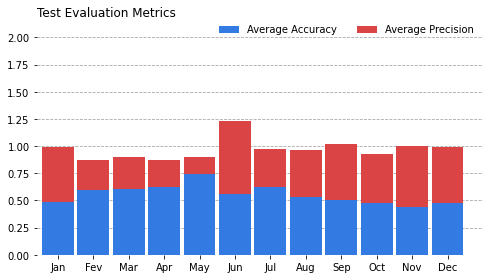

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

d = {'Average Accuracy':[test_results[i][0] for i in range(len(test_results))], 'Average Precision': [test_results[i][1] for i in range(len(test_results))]}
result_df = pd.DataFrame(data=d)
result_df

fig, ax = plt.subplots(1, figsize=(8, 4))
plt.bar(result_df.index, result_df['Average Accuracy'], color = '#337AE3', width = 0.9)
plt.bar(result_df.index, result_df['Average Precision'], bottom = result_df['Average Accuracy'], color = '#DB4444', width = 0.9)
plt.xlim(-0.6, 12)
plt.ylim(0, 2)# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)#grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)# x ticks
xticks_labels = ['Jan', 'Fev', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(result_df.index , labels = xticks_labels)# title and legend
legend_label = ['Average Accuracy', 'Average Precision']
plt.legend(legend_label, ncol = 4, bbox_to_anchor=([1, 1.1, 0, 0]), frameon = False)
plt.title('Test Evaluation Metrics\n', loc='left')
plt.show()

In [58]:
print(last_predicted_values.shape)
print(last_labels.shape)

torch.Size([1255, 2])
torch.Size([1255])


## 3. Interpretation

In [59]:
fine_predicted_classes = torch.max(fine_predicted_values, dim=1).indices
fine_predicted_classes_list = fine_predicted_classes.tolist()

fine_labels_list = fine_labels.tolist()

In [61]:
print(soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()])
print(soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()])

lons_smaller = soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()]
lats_smaller = soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()]

soda_coordinates = []
for index in range(len(lats_smaller)):
  if fine_test_masks[index] == True:
    soda_coordinates.append([lons_smaller[index], lats_smaller[index], True])
  else:
    soda_coordinates.append([lons_smaller[index], lats_smaller[index], False])

for element in soda_coordinates:
  if element[2] == True:
    element.append(fine_predicted_classes_list[0])
    fine_predicted_classes_list = fine_predicted_classes_list[1:]
    element.append(fine_labels_list[0])
    fine_labels_list = fine_labels_list[1:]

print(soda_coordinates)
print(len(fine_predicted_classes_list), len(fine_labels_list))

[162.75 165.25 167.75 ... 352.75 355.25 357.75]
[-74.75 -74.75 -74.75 ...  87.75  87.75  87.75]
[[162.75, -74.75, False], [165.25, -74.75, False], [167.75, -74.75, False], [170.25, -74.75, True, 0, 0], [172.75, -74.75, False], [175.25, -74.75, False], [177.75, -74.75, False], [180.25, -74.75, False], [182.75, -74.75, False], [185.25, -74.75, False], [187.75, -74.75, False], [190.25, -74.75, True, 0, 1], [192.75, -74.75, True, 0, 1], [195.25, -74.75, False], [197.75, -74.75, False], [200.25, -74.75, False], [202.75, -74.75, False], [205.25, -74.75, False], [207.75, -74.75, False], [210.25, -74.75, False], [212.75, -74.75, False], [215.25, -74.75, False], [217.75, -74.75, False], [220.25, -74.75, False], [222.75, -74.75, False], [225.25, -74.75, False], [227.75, -74.75, True, 0, 0], [300.25, -74.75, False], [302.75, -74.75, False], [305.25, -74.75, False], [307.75, -74.75, True, 0, 0], [310.25, -74.75, True, 0, 0], [312.75, -74.75, False], [315.25, -74.75, False], [317.75, -74.75, False]

In [119]:
df_fine_soda = pd.DataFrame(soda_coordinates, columns=['Longitude', 'Latitude', 'Test Mask', 'Predicted Class', 'Observed Class'])
df_fine_soda.dtypes

Longitude          float32
Latitude           float32
Test Mask             bool
Predicted Class    float64
Observed Class     float64
dtype: object

In [120]:
df_fine_soda = df_fine_soda.dropna()
df_fine_soda = df_fine_soda.replace(0.0, 'No MHW').replace(1.0, 'MHW')
df_fine_soda

,Longitude,Latitude,Test Mask,Predicted Class,Observed Class
3,170.25,-74.75,True,No MHW,No MHW
11,190.25,-74.75,True,No MHW,MHW
12,192.75,-74.75,True,No MHW,MHW
26,227.75,-74.75,True,No MHW,No MHW
30,307.75,-74.75,True,No MHW,No MHW
...,...,...,...,...,...
6897,292.75,87.75,True,No MHW,No MHW
6899,297.75,87.75,True,No MHW,No MHW
6906,315.25,87.75,True,No MHW,No MHW
6914,335.25,87.75,True,No MHW,No MHW


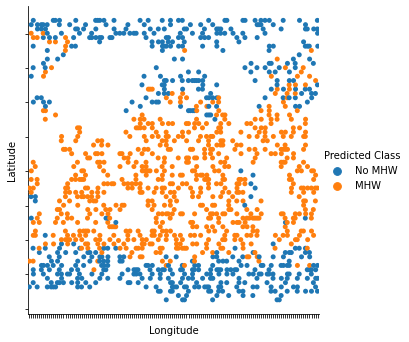

In [117]:
import seaborn as sns

ax1 = sns.catplot(x='Longitude', y='Latitude', hue='Predicted Class', data = df_fine_soda)
ax1.set(xticklabels=[], yticklabels=[])
plt.show()

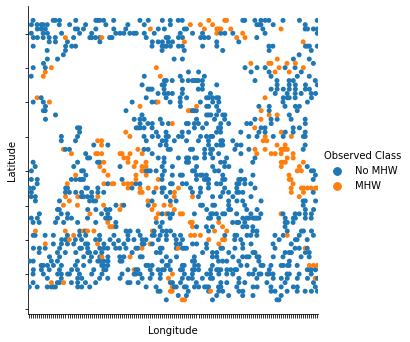

In [118]:
ax2 = sns.catplot(x='Longitude', y='Latitude', hue='Observed Class', data = df_fine_soda)
ax2.set(xticklabels=[], yticklabels=[])
plt.show()